## La vida del data scientist

El equipo de marketing de la empresa X quiere tomar decisiones para alocar presupuesto en base al valor futuro de los usuarios. Para ello se nos ha encargado desarrollar un modelo de LTV(file time value) que consista en predecir el valor futuro de cada usuario.

Debido a que esta problematica es compleja, vamos a dividir el problema en 3 partes:
- 1- Vamos a predecir si el usuario va a churnear (no va a comprar en el próximo año)

- 2- Vamos a hacer un analisis clasico llamado RFM para entender como se segmentan nuestros usuarios

- 3- Vamos a ponerle un valor a la cantidad de compras que realizará a futuro

Para ello, se nos ha proporcionado un dataset -que afortunadamente nos dejaron los datos limpios (esto solo pasa en la facultad jeje)- para que podamos entrenar nuestro modelo. 

El datset consiste en los siguientes campos:
- cust: ID del usuarios
- Freq_2Y: Dias distintos de pago en ultimos 2 años
- Freq_1Y: Dias distintos de pago en ultimos 1 años
- Freq_3M: Dias distintos de pago en ultimos 3 meses
- Recency: Cantidad de dias desde ultima compra
- first_in_windows: Cantidad de dias desde primer compra
- IPT_mean: Intervalo entre compra y compra
- CREDIT_PAY: Pagos con tarjeta de credito
- TIPO_TARJETA
- CUS_FIRST_BUY: Dias desde primer compra
- CANTIDAD_COMPRAS_ITEMS_USADOS
- cant_dias_active_short: dias distintos de visita al sitio
- recency_date_short: Dias desde ultima visita
- Frequency_target: Dias distinto de compra en el próximo año

## 1) Levantamos el dataset

In [ ]:
import pandas as pd
dataset = pd.read_csv("DATASET_LTV.csv") # Levantamos el dataset

# dataset.head()  # Siempre que levantamos un archivo vemos levantamos ;)

FileNotFoundError: ignored

#### Es coherente lo que vemos? 
Pista: Usa el parametro sep

In [ ]:
dataset = pd.read_csv("DATASET_LTV.csv",sep = ";")
dataset.head()

,cust,Recency,first_in_windows,Freq_2Y,Freq_1Y,Freq_3M,IPT_mean,CREDIT_PAY,TIPO_TARJETA,CUS_FIRST_BUY,CANTIDAD_COMPRAS_ITEMS_USADOS,cant_dias_active_short,recency_date_short,Frequency_target
0,378518804,294.0,294.0,1,1,0.0,9.999999e+06,1.0,2.0,294.0,0,0.0,9999999.0,0.0
1,389613070,4.0,4.0,1,1,1.0,9.999999e+06,0.0,0.0,4.0,0,0.0,9999999.0,0.0
2,56668186,42.0,545.0,9,8,2.0,1.304561e+00,8.0,4.0,3114.0,0,1.0,27.0,14.0
3,307374346,14.0,544.0,6,5,1.0,1.301598e+00,7.0,2.0,544.0,0,3.0,1.0,6.0
4,211220646,31.0,48.0,3,3,3.0,9.097720e-01,0.0,0.0,48.0,0,5.0,16.0,1.0


# CHURN

## 2) Exploramos el dataset
Pista: 
- cust es un ID. LOS IDS NUNCA LOS USAMOS PARA ENTRENAR, son solo referencias para joinear en las tablas.
- Ver cuales son los tipos de datos: Binarios (1-0), countinuos(1.23242, 2.92e-3), discretos(1,2,3,4,5), categoricos("cat1","cat2","cat5")
- Ver como esta balanceado el target
- Ver cuales son los outliers y como se distribuyen los datos

In [ ]:
# Miro balanceo de clases. Vemos que la clase esta bastante balanceada!
import numpy as np

dataset["churn"] = np.where(dataset.Frequency_target == 0,1,0)
dataset["churn"].value_counts()/dataset.shape[0]

0    0.6368
1    0.3632
Name: churn, dtype: float64

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


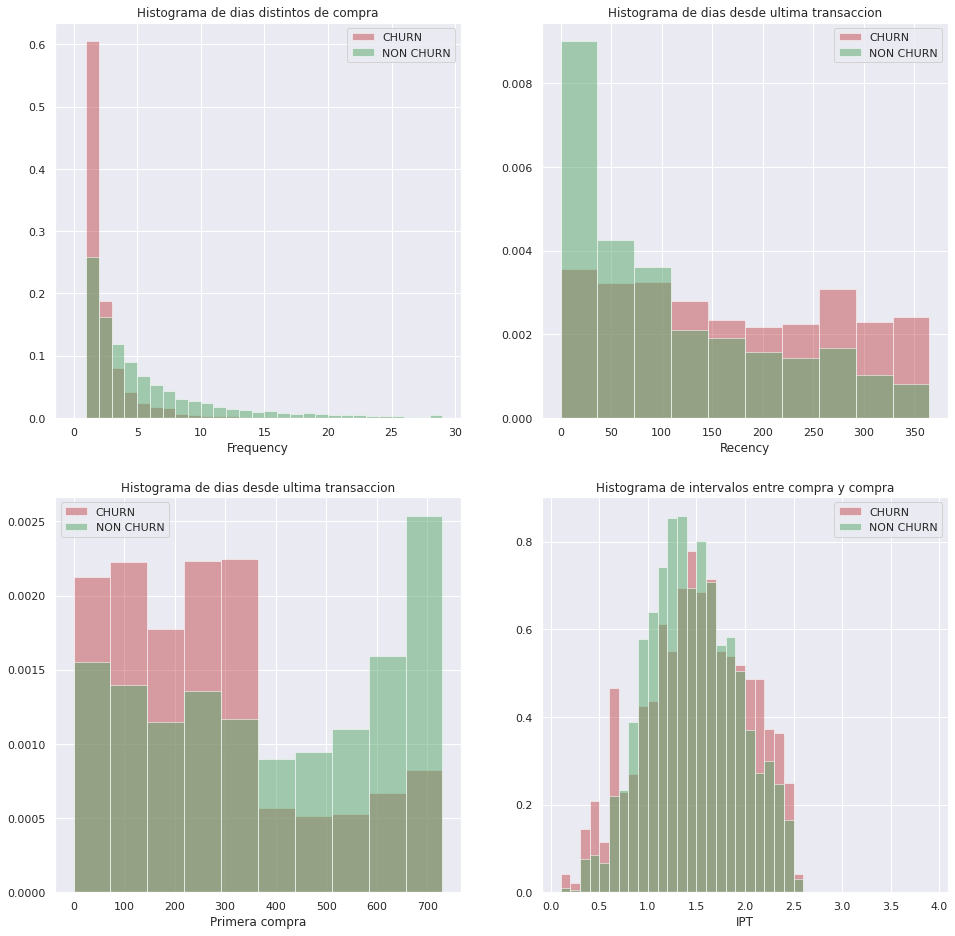

In [ ]:
# Miramos cual es la relacion entre variables con el target

# Como la division entre churners vs non churners no es exactamente 50-50 vamos a hacer un viejo truco 
# para que la etapa de exploracion sea mas rapido. Tomamos un sample (muestreo aleatorio) de la clase mayoritaria
import matplotlib.pyplot as plt
import seaborn as sns
churners = dataset.loc[dataset.churn == 1]
non_churners = dataset.loc[dataset.churn == 0].sample(n = churners.shape[0]) # Truquito 

sns.set(font_scale = 1)
fig, ax = plt.subplots(figsize=(16,16),nrows=2,ncols = 2)
ax[0,0].hist(churners.Freq_2Y,bins = range(0,30),color = "r",alpha = 0.5,density = True)
_ = ax[0,0].hist(non_churners.Freq_2Y,bins = range(0,30),color = "g", alpha = 0.5,density = True)
ax[0,0].set_xlabel("Frequency")
ax[0,0].title.set_text("Histograma de dias distintos de compra")
ax[0,0].legend(["CHURN","NON CHURN"])

ax[0,1].hist(churners.Recency,color = "r",alpha = 0.5,density = True)
_ = ax[0,1].hist(non_churners.Recency,color = "g", alpha = 0.5,density = True)
ax[0,1].set_xlabel("Recency")
ax[0,1].title.set_text("Histograma de dias desde ultima transaccion")
ax[0,1].legend(["CHURN","NON CHURN"])

ax[1,0].hist(churners["first_in_windows"],color = "r",alpha = 0.5,density = True)
_ = ax[1,0].hist(non_churners["first_in_windows"],color = "g", alpha = 0.5,density = True)
ax[1,0].set_xlabel("Primera compra")
ax[1,0].title.set_text("Histograma de dias desde ultima transaccion")
ax[1,0].legend(["CHURN","NON CHURN"])

ax[1,1].hist(churners["IPT_mean"],bins = np.arange(0.1,4,0.1),color = "r",alpha = 0.5,density = True)
_ = ax[1,1].hist(non_churners["IPT_mean"],bins = np.arange(0.1,4,0.1),color = "g", alpha = 0.5,density = True)
ax[1,1].set_xlabel("IPT")
ax[1,1].title.set_text("Histograma de intervalos entre compra y compra")
ax[1,1].legend(["CHURN","NON CHURN"])

In [ ]:
# Si el target (churn) es discreto, NO podremos hacer una correlacion! Si nuestro feature es continuo. 
# Para esto lo que necesitamos es ver si hay separacion de medias. Vamos a usar un test de hipotesis llamado ttest

from scipy.stats import ttest_ind

churners = dataset.loc[dataset.churn == 1]
non_churners = dataset.loc[dataset.churn == 0].sample(n = churners.shape[0]) # Truquito 

train_cols = ['Recency', 'first_in_windows', 'Freq_2Y', 'Freq_1Y', 'Freq_3M',
       'IPT_mean', 'CREDIT_PAY', 'TIPO_TARJETA',
       'CUS_FIRST_BUY', 'CANTIDAD_COMPRAS_ITEMS_USADOS',
       'cant_dias_active_short', 'recency_date_short']

print("Pvalue < 0.05 implica que no tenemos evidencia para rechazar hipotesis de que medias son iguales")
for c in train_cols:
  print(c,ttest_ind(non_churners[c].values,churners[c].values).pvalue)

Pvalue < 0.05 implica que no tenemos evidencia para rechazar hipotesis de que medias son iguales
Recency 2.0673321692508598e-133
first_in_windows 2.931312418416819e-112
Freq_2Y 8.38169054437481e-112
Freq_1Y 6.5856744331832954e-127
Freq_3M 5.268379332364358e-130
IPT_mean 1.0386774389990448e-215
CREDIT_PAY 2.5503467872377414e-53
TIPO_TARJETA 4.730200198403469e-37
CUS_FIRST_BUY 1.1676381495671397e-61
CANTIDAD_COMPRAS_ITEMS_USADOS 2.3089399564190577e-13
cant_dias_active_short 4.499276442607559e-189
recency_date_short 1.2498856544345985e-173


## 3) Hora de modelar

Antes dividimos el dataset entre test- train segun las sagradas leyes:
- 1- No entrenar datos con datos test
- 2- Nunca entrenar datos con datos test
- 3- Jamas entrenar datos con datos test

In [ ]:
train_cols = ['Recency', 'first_in_windows', 'Freq_2Y', 'Freq_1Y', 'Freq_3M',
       'IPT_mean', 'CREDIT_PAY', 'TIPO_TARJETA',
       'CUS_FIRST_BUY', 'CANTIDAD_COMPRAS_ITEMS_USADOS',
       'cant_dias_active_short', 'recency_date_short']

In [ ]:
from sklearn.model_selection import train_test_split

# Si usas el campo stratify de train_test_split mejor ;) https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test  = train_test_split(dataset[train_cols],dataset.churn,random_state=42,test_size = 0.3,stratify = dataset.churn) # el dataset esta un poco desbalanceado, es conveniente splitear con este campo. Si tenemos un balanceo ej: 70-30, luego train y test deben tener el mismo balanceo

# Vamos a probar con la conocida regresion logistica. Primero standarizamos por si alguien quiere hacer combinacion de features..._
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std = std.fit(X_train)  # Calculamos media y desvio sobre los datos de trianing

# aplicamos transformacion sobre lo aprendido
X_train_s = std.transform(X_train)
X_test_s = std.transform(X_test)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "class_weight":[None,"balanced"]}

# Entrenar usando curva ROC
lr=LogisticRegression()
search=GridSearchCV(lr,param_grid,cv=3,n_jobs=-1,scoring="roc_auc")
search.fit(X_train_s,y_train)

print("AUC:",search.best_score_)
search.best_estimator_  # Nos fijamos cuales son los mejores estimadores para ver si no tenemos que aumentar la grilla

AUC: 0.7815934539558503


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Y si queremos agregar PCA a nuestro pipeline de modelado? Se empieza a complicar todo. Mejora?
# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipe = Pipeline(steps=[('std', StandardScaler()),('pca', PCA()), ('logistic', LogisticRegression())])
grid = [{"pca__n_components":list(range(5,len(train_cols)-1)),
         "logistic__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
         "logistic__class_weight":[None,"balanced"]
         }]
         
search_lr=GridSearchCV(pipe,grid,cv=3,n_jobs=-1,scoring="roc_auc")
search_lr.fit(X_train,y_train)

print("AUC:",search_lr.best_score_)
search_lr.best_estimator_

AUC: 0.7815460624195855


Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=10,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logistic',
                 LogisticRegression(C=0.01, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
# Probemos con knn. Sabemos que es lento y que no es robusto, veamos como funciona...

from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline(steps=[('std', StandardScaler()), ('knn', KNeighborsClassifier())])
grid = [{"knn__n_neighbors": np.arange(200,500,20),
         "knn__metric":["l2","l1"]
         }]
         
search_knn=GridSearchCV(pipe,grid,cv=3,n_jobs=-1,scoring="roc_auc")
search_knn.fit(X_train,y_train)

print("AUC:",search_knn.best_score_)
search_knn.best_estimator_

AUC: 0.778482271914577


Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='l1', metric_params=None,
                                      n_jobs=None, n_neighbors=320, p=2,
                                      weights='uniform'))],
         verbose=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline(steps=[('std', StandardScaler()),('rf', RandomForestClassifier())])

grid = [{'rf__n_estimators': [100,200, 500,800, 1200,1800],
            'rf__max_features': ['auto', 'sqrt', 'log2'],
            'rf__max_depth' : [4,5,6,7,8],
            'rf__criterion' :['gini', 'entropy']
         }]
         
search_rf=GridSearchCV(pipe,grid,cv=3,n_jobs=-1,scoring="roc_auc",verbose = 10) # Con el parametro verbose podemos ver si nuestra CPU esta trabajando o se quedo algo tildado...
search_rf.fit(X_train,y_train)

print("AUC:",search_rf.best_score_)
search_rf.best_estimator_

# Creen que esto terminara antes de las 10? Vamos con un atajo ;)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    6.4s


KeyboardInterrupt: ignored

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

grid = [{'n_estimators': [10,50,100,200, 500,800, 1200,1800],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth' : [4,5,6,7,8],
            'criterion' :['gini', 'entropy']
         }]
         
search_rf=RandomizedSearchCV(rf,grid,cv=3,n_jobs=-1,scoring="roc_auc",verbose = 10,n_iter = 30)
search_rf.fit(X_train,y_train)

print("AUC:",search_rf.best_score_)
search_rf.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.6min finished


AUC: 0.7839467365028909


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Text(0.5, 0, 'Feature Importance')

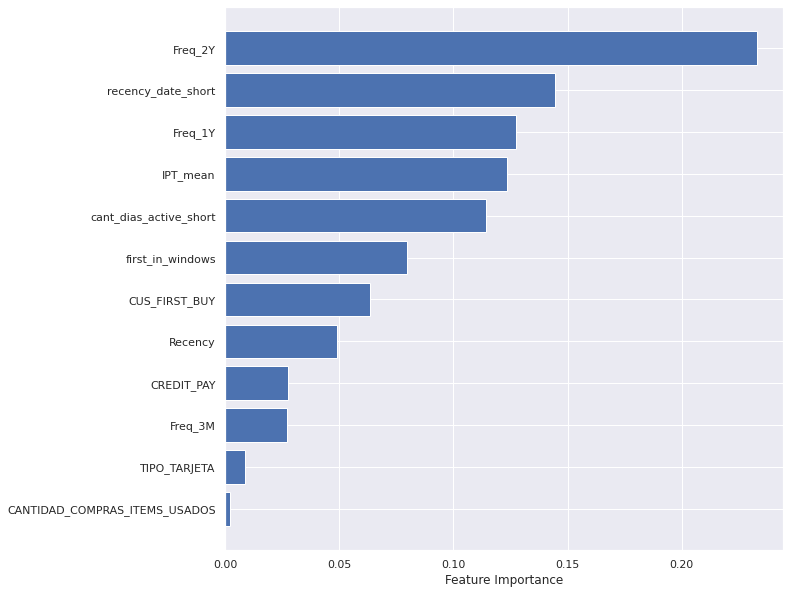

In [ ]:
# los modelos de arboles nos permiten hacer un analisis de importancia de variables:
winning_rf = search_rf.best_estimator_
importance = winning_rf.feature_importances_

# armo un df para hacer el ordenamiento por feature importance
df = pd.DataFrame(importance,columns = ["imp"])
df["col_name"] = train_cols
df = df.sort_values(by="imp",ascending = False) # Ordeno de forma descendente

fig, ax = plt.subplots(figsize=(10,10))
y_pos = np.arange(len(df.col_name.values))
ax.barh(y_pos,df.imp.values , align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df.col_name.values)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')


In [ ]:
# Probemos con grandient boosting!
from sklearn.ensemble import GradientBoostingClassifier

parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10,50,100,250,500,1000]
    }

gb = GradientBoostingClassifier()

grid = [{"learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2], # learning reate del gradiente, es lo que le da sentido al gradient ;)
          "min_samples_split": np.linspace(0.1, 0.5, 12),
          "min_samples_leaf": np.linspace(0.1, 0.5, 12),
          "max_depth":[3,5,8], # prevenimos overfitting
          "max_features":["log2","sqrt"],
          "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0], # super importante! combina features a tomar
          "n_estimators":[10,50,100,250,500,1000] 
         }]
         
search_gb=RandomizedSearchCV(gb,grid,cv=3,n_jobs=-1,scoring="roc_auc",verbose = 10,n_iter = 10)
search_gb.fit(X_train,y_train)

print("AUC:",search_gb.best_score_)
search_gb.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.7s finished


AUC: 0.7834678817046191


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.025, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=0.2090909090909091,
                           min_samples_split=0.5, min_weight_fraction_leaf=0.0,
                           n_estimators=500, n_iter_no_change=None,
                           presort='deprecated', random_state=None,
                           subsample=1.0, tol=0.0001, validation_fraction=0.1,
                           verbose=0, warm_start=False)

# 4) Ya tenemos muchos modelos dando vuelta, que empiece la competencia...

Cuando miramos la curva ROC, comparamos:
- FPR: Del total de negativos, que porcentaje predecimos mal
- TPR: Del total de positivos, que porcentaje agarramos (Recall)

Como estamos trabajando para marketing, queremos maximizar el TPR ya que queremos alcanzar a la mayoria de los usuarios que realmente vayan a churn, pero como el presupuesto es acotado queremos reducir los falsos positivos ya que vamos a estar pagando por personas que en realidad no van a estar churneando.

Como no nos han dado una penalizacion por falso positivo, vamos a buscar un punto de quiebre en la curva para el cual el crecimiento de TPR se reduzca. Podemos ver que para un FPR = 0.3 cumplimos con esta condicion 

LR AUC: Train 0.7815460624195855 || Test 0.7830820404438252
KNN AUC: Train 0.778482271914577 || Test 0.7822251308900523
RF AUC: Train 0.7839467365028909 || Test 0.786964311446275
GB AUC: Train 0.7834678817046191 || Test 0.7857243383447814


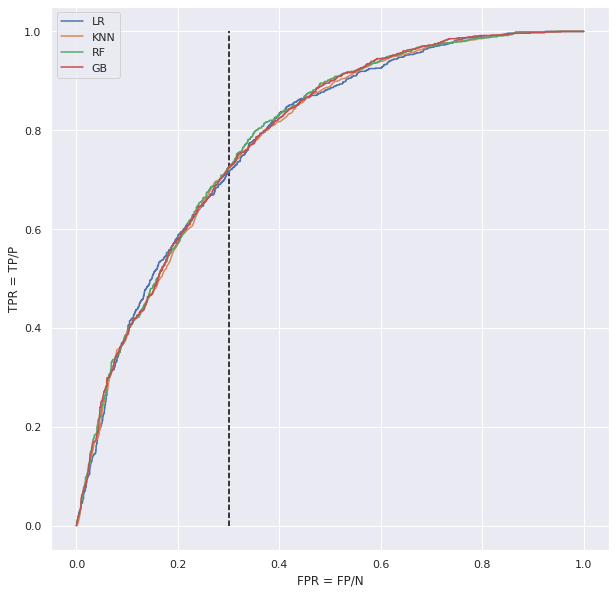

In [ ]:
# Ploteamos la curva
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

plt.figure(figsize=(10,10))
fpr,tpr,tresh = roc_curve(y_test,search_lr.predict_proba(X_test)[:,1])
auc_lr = roc_auc_score(y_test,search_lr.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
fpr,tpr,tresh = roc_curve(y_test,search_knn.predict_proba(X_test)[:,1])
auc_KNN= roc_auc_score(y_test,search_knn.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
fpr,tpr,tresh = roc_curve(y_test,search_rf.predict_proba(X_test)[:,1])
auc_RF= roc_auc_score(y_test,search_rf.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
fpr,tpr,tresh = roc_curve(y_test,search_gb.predict_proba(X_test)[:,1])
auc_GB = roc_auc_score(y_test,search_gb.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)

plt.ylabel("TPR = TP/P")
plt.xlabel("FPR = FP/N")
plt.legend(["LR","KNN","RF","GB"])

plt.vlines(x=0.3,ymin=0,ymax=1,linestyles="dashed",color ="black")
print("LR AUC: Train {} || Test {}".format(search_lr.best_score_,auc_lr))
print("KNN AUC: Train {} || Test {}".format(search_knn.best_score_,auc_KNN))
print("RF AUC: Train {} || Test {}".format(search_rf.best_score_,auc_RF))
print("GB AUC: Train {} || Test {}".format(search_gb.best_score_,auc_GB))


In [ ]:
# A partir de la curva, elegimos el modelo que mayor TPR tenga para el corte negro. Ganador: Random Forest

win_model = search_rf
fpr,tpr,tresh = roc_curve(y_test,search_rf.predict_proba(X_test)[:,1])

df = pd.DataFrame(list(tresh),columns=["tresh"])
df["TPR"] = tpr
df["FPR"] = fpr

treshold = df.loc[np.abs(df.FPR - 0.3) < 0.01].head(1).tresh.values[0]

print("Treshold Ganador:",treshold)

# Aplicamos el umbral:
y_tresh = np.where(win_model.predict_proba(X_test)[:,1] >= treshold,1,0 )

Treshold Ganador: 0.4169966656556755


              precision    recall  f1-score   support

           0       0.81      0.71      0.76      1910
           1       0.58      0.71      0.64      1090

    accuracy                           0.71      3000
   macro avg       0.70      0.71      0.70      3000
weighted avg       0.73      0.71      0.71      3000



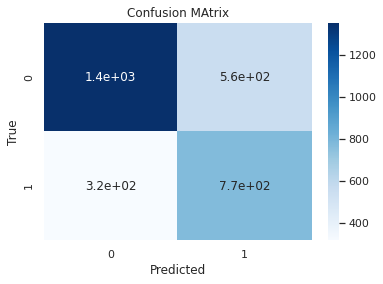

In [ ]:
# Vemos como nos queda la matriz de confusion con este corte y sus metricas asociadas:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_tresh)
sns.heatmap(cf_matrix, annot=True,cmap='Blues')
plt.title("Confusion MAtrix")
plt.ylabel("True")
plt.xlabel("Predicted")
print(classification_report(y_test,y_tresh))

# 5) Ya tenemos el modelo y el umbral. Solo queda guardar el modelo y el umbral para usarlo!

Vamos a usar pickle, una libreria bastante sencilla que guarda el modelo en formato pickle. Pickle es un formato binario con checkeo de errores.

In [ ]:
import pickle

with open('model.pkl', 'wb') as fout:
    pickle.dump(win_model, fout)

# 6) Simulamos poner el modelo en produccion

Le avisamos a marketing que teniamos el modelo, le dimos descuento a los usuarios para retenerlos y nos fue muy bien :) Asi que pasado el tiempo nos vuelven a pedir que scoriemos nuevos usuarios... por suerte ya habiamos guardado el modelo y su treshold, con lo cual es solo cuestion de volver a aplicar el modelo.

In [ ]:
TRESHOLD = 0.4169966656556755  # este es el umbral que me habia dado a mi

train_cols = ['Recency', 'first_in_windows', 'Freq_2Y', 'Freq_1Y', 'Freq_3M',
       'IPT_mean', 'CREDIT_PAY', 'TIPO_TARJETA',
       'CUS_FIRST_BUY', 'CANTIDAD_COMPRAS_ITEMS_USADOS',
       'cant_dias_active_short', 'recency_date_short']

with open("model.pkl", 'rb') as file:
    model = pickle.load(file)

new_data = pd.read_csv("DATASET_LTV.csv",sep=";") # hagamos de cuenta que son nuevos usuarios

new_data["predicions"] = np.where(model.predict_proba(new_data[train_cols])[:,1] >= TRESHOLD,1,0 ) # usar predict_proba y umbralizar

print("Detectamos a {} usuarios".format(new_data.loc[new_data.predicions == 1].shape[0]))# Nos fijamos a cuantos usuarios detectamos

# Guardo el segmento de usuarios para mandarles descuentos
new_data.loc[new_data.predicions == 1][["cust"]].to_csv("ENVIARLES_DESCUENTO.csv",index=False)

Detectamos a 4454 usuarios
